In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

In [3]:
# Load data (example)
LOAD = 'samples'

if LOAD == 'samples':
    mysamples = {
        'CTRL' : '../data/samples/PBMC.mtx',
        'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
        'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
        'IL2_10ng/ml' : '../data/samples/IL2.mtx',
        'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
    }
    mygenes = '../data/samples/genes.tsv'
    pop = PA.load_samples(samples=mysamples, 
                          genes=mygenes)
    
elif LOAD == 'screen':
    mymatrix = '../data/screen/drug_screen/pbmcmult4cd3minus.mtx'
    mybarcodes = '../data/screen/drug_screen/barcodes.tsv'
    mygenes = '../data/screen/drug_screen/features.tsv'
    mymetadata = '../data/screen/drug_screen/meta.csv'
    pop = PA.load_screen(matrix=mymatrix, 
                         barcodes=mybarcodes, 
                         metafile=mymetadata, 
                         genes=mygenes)

In [4]:
# Perform column normalization
# Find best normalization factor
PA.normalize(pop)

Performing column normalization
Finding best normalization factor


1490 genes selected


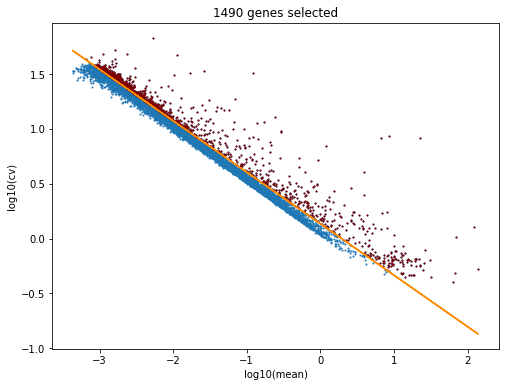

In [5]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
PA.plot_gene_filter(pop, offset=1.1)

In [6]:
# Gene filter the data with the last offset value used in the previous step
PA.filter(pop)

Removing ribosomal genes
Filtering genes ang logging data


In [7]:
# Remove red blood cells from the data
PA.removeRBC(pop, 'human')

CTRL 1349 cells kept out of 1377
GMCSF_1ng/ml 1424 cells kept out of 1444
IFNG_1ng/ml 1125 cells kept out of 1144
IL2_10ng/ml 1633 cells kept out of 1654
CD40L_20ng/ml 2326 cells kept out of 2358


In [8]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=300)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #299
......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

......... Iteration #299
......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Computing reconstruction errors
Progress: 1 of 6
Progress: 2 of 6
Progress: 3 of 6
Progress: 4 of 6
Progress: 5 of 

In [9]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
importlib.reload(PA) 
PA.build_gmms(pop, 
              ks=(5,20), 
              niters=3, 
              training=.8, 
              nreplicates=3, 
              reg_covar=True, 
              rendering='grouped', 
              types=None)

Building model for CTRL (1 of 5)
Building model for GMCSF_1ng/ml (2 of 5)
Building model for IFNG_1ng/ml (3 of 5)
Building model for IL2_10ng/ml (4 of 5)
Building model for CD40L_20ng/ml (5 of 5)
Rendering models


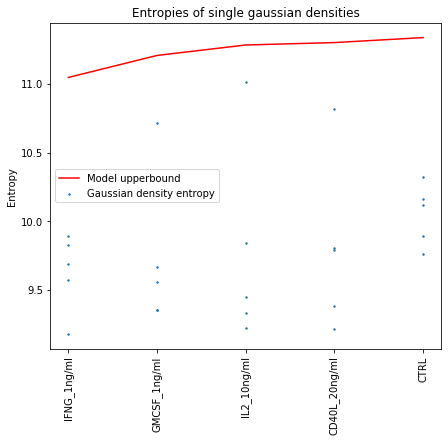

In [10]:
# Calculate all the subpopulations entropies for each samples
importlib.reload(PA)
PA.entropy(pop)

In [15]:
# Align subpopulations of each sample against a reference model's subpopulations
importlib.reload(PA)
PA.align(pop, ref='CTRL', method='conservative')

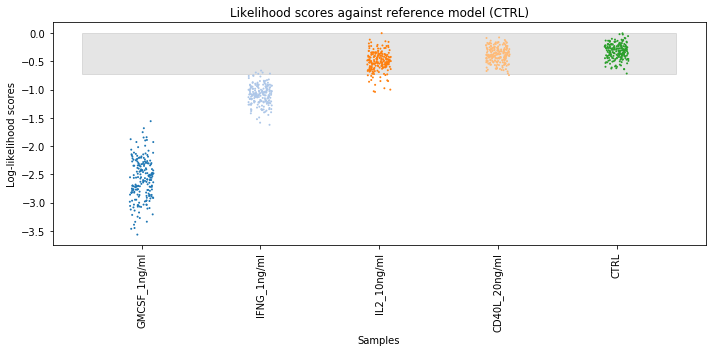

In [12]:
# Rank each sample against a reference sample's model
PA.rank(pop, ref='CTRL', k=100, niter=200, mincells=50)

In [13]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, ks=(5,20), niters=3, reg_covar=True, types=None)

In [14]:
# Generate a query plot
importlib.reload(PA)
PA.plot_query(pop)
PA.plot_query_heatmap(pop)

Plot saved under output/query/query_plot.pdf
Plot saved under output/query/query_heatmap.pdf


In [ ]:
# Interactive 3D visualization of the data in feature space
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

In [16]:
import os
import csv
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import io as sio
from scipy import sparse as ss
from scipy import optimize as so
from scipy import stats
from scipy.stats import linregress
from scipy.cluster import hierarchy as shc
from scipy.spatial import distance as scd
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import mixture as smix
import fastcluster as fc
from sklearn import cluster as sc
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
import adjustText
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout, HBox, VBox, fixed
from textwrap import wrap
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.offline import iplot

In [ ]:
def l1norm()

In [ ]:
pop['ref']

In [ ]:
x1 = 'Budesonide'
x2 = pop['ref']
i1, i2 = pop['samples'][x1]['alignments'][0][:2]
M1 = pop['samples'][x1]['M']
M2 = pop['samples'][x2]['M']

prediction1 = pop['samples'][x1]['gmm'].predict(pop['samples'][x1]['C'])
idx1 = np.where(prediction1==i1)[0]
sub1 = M1[:,idx1]

prediction2 = pop['samples'][x2]['gmm'].predict(pop['samples'][x2]['C'])
idx2 = np.where(prediction2==i2)[0]
sub2 = M2[:,idx2]


In [ ]:
g = 'CD3D'
ig = np.where(pop['genes']==g)[0][0]

arr1 = sub1[ig,:].toarray()
arr2 = sub2[ig,:].toarray()
max1, max2 = np.max(arr1), np.max(arr2)

nbins = 10
b1, be1 = np.histogram(arr1, bins=nbins, range=(0,max(max1,max2)))
b2, be2 = np.histogram(arr2, bins=nbins, range=(0,max(max1,max2)))
b1 = b1/len(idx1)
b2 = b2/len(idx2)

norm = np.linalg.norm(np.abs(b1-b2))

In [ ]:
plt.plot(be1[:-1], b1, label='comp1')
plt.plot(be1[:-1], b2, label='comp2')
plt.legend()

In [ ]:
b1

In [ ]:
b2

In [ ]:
b1-b2

In [ ]:
np.abs(b1-b2)

In [ ]:
np.linalg.norm(np.abs(b1-b2))

In [ ]:
for i in range(sub1.shape[0]):
    sub1[i,:].toarray()